In [12]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

# Visualization
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Error metrics
from sklearn.metrics import mean_squared_error

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Install missing packages
# pip install pandas-datareader keras tensorflow

In [14]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500's, 'DJIA', 'VIXCLS']

In [16]:
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

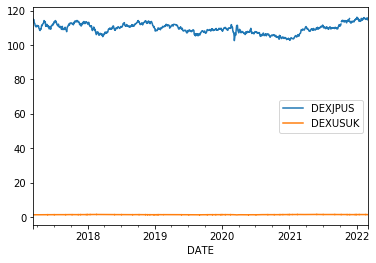

In [17]:
ccy_data.plot();

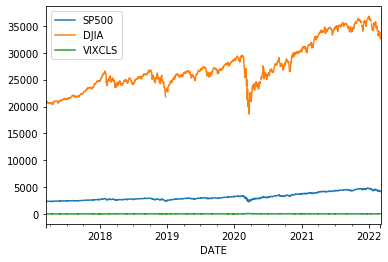

In [18]:
idx_data.plot();

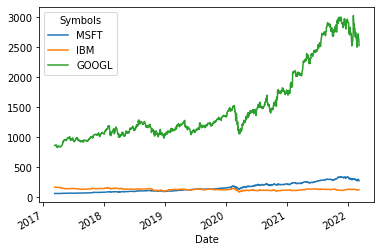

In [19]:
stk_data['Open'].plot();

In [20]:
return_period = 5

In [21]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

In [22]:
Y.name = 'MSFT_pred'

In [23]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, 
                                                                            return_period * 3, 
                                                                            return_period * 6, 
                                                                            return_period * 12]
          ], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1,X2,X3,X4], axis=1)

dataset = pd.concat([X,Y], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

#### Exploratory data analysis

##### 3.1 Descriptive analysis

In [24]:
pd.set_option('precision', 3)
dataset.describe()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
count,2.250e+02,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,-4.837e-04,0.004,1.838e-04,-1.331e-04,0.002,0.001,0.007,0.006,0.020,0.039,0.082,0.006
std,3.417e-02,0.036,9.530e-03,1.263e-02,0.023,0.025,0.169,0.032,0.052,0.065,0.077,0.030
min,-1.304e-01,-0.132,-4.010e-02,-9.152e-02,-0.134,-0.169,-0.485,-0.104,-0.198,-0.246,-0.154,-0.105
25%,-1.519e-02,-0.015,-5.373e-03,-6.851e-03,-0.004,-0.008,-0.091,-0.011,-0.009,0.007,0.038,-0.011
50%,3.080e-03,0.005,9.259e-04,0.000e+00,0.004,0.004,-0.012,0.008,0.025,0.044,0.086,0.008
75%,1.853e-02,0.024,6.563e-03,8.210e-03,0.013,0.012,0.084,0.026,0.051,0.081,0.135,0.025
max,1.263e-01,0.145,3.414e-02,5.225e-02,0.107,0.112,0.707,0.101,0.186,0.227,0.346,0.082


In [25]:
dataset.head()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
2017-06-06,0.004,5.118e-04,-0.012,3.339e-03,0.007,0.005,0.007,0.030,0.064,0.077,0.116,-0.026
2017-06-13,0.012,-2.662e-02,0.007,-1.264e-02,0.005,0.009,-0.003,-0.026,0.032,0.023,0.091,-0.011
2017-06-20,0.005,-1.557e-03,0.012,-8.752e-03,-0.001,0.006,0.041,-0.011,-0.007,0.020,0.079,-0.010
2017-06-27,-0.001,-2.180e-02,0.009,1.283e-02,-0.007,-0.007,0.018,-0.010,-0.047,0.017,0.055,-0.002
2017-07-05,-0.007,-1.684e-02,0.009,-1.546e-04,-0.003,0.001,0.099,-0.002,-0.022,0.009,0.056,0.030


In [26]:
dataset.dtypes

IBM          float64
GOOGL        float64
DEXJPUS      float64
DEXUSUK      float64
SP500        float64
DJIA         float64
VIXCLS       float64
MSFT_DT      float64
MSFT_3DT     float64
MSFT_6DT     float64
MSFT_12DT    float64
MSFT_pred    float64
dtype: object

##### 3.2 Data visualization

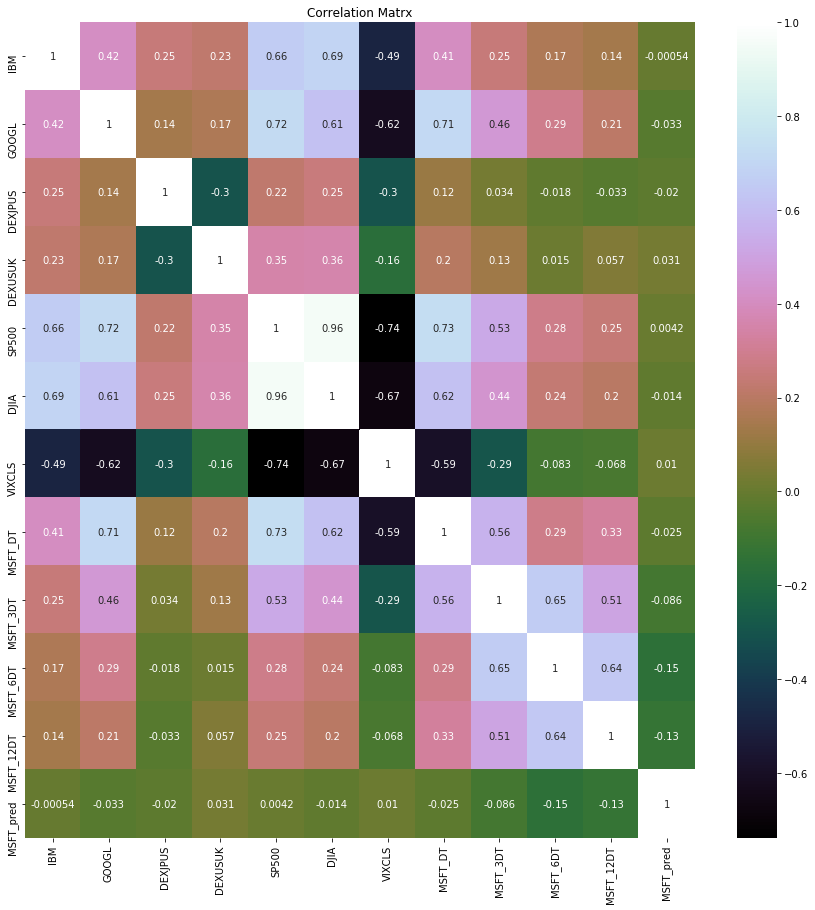

In [27]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrx')
sns.heatmap(correlation, vmax=1, annot=True, cmap='cubehelix')

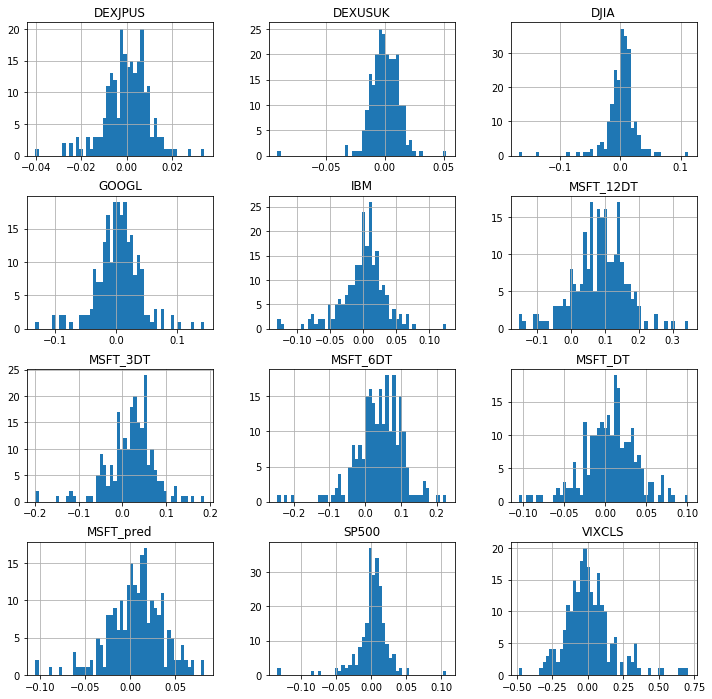

In [28]:
dataset.hist(bins=50, sharex=False, sharey=False,figsize=(12,12));

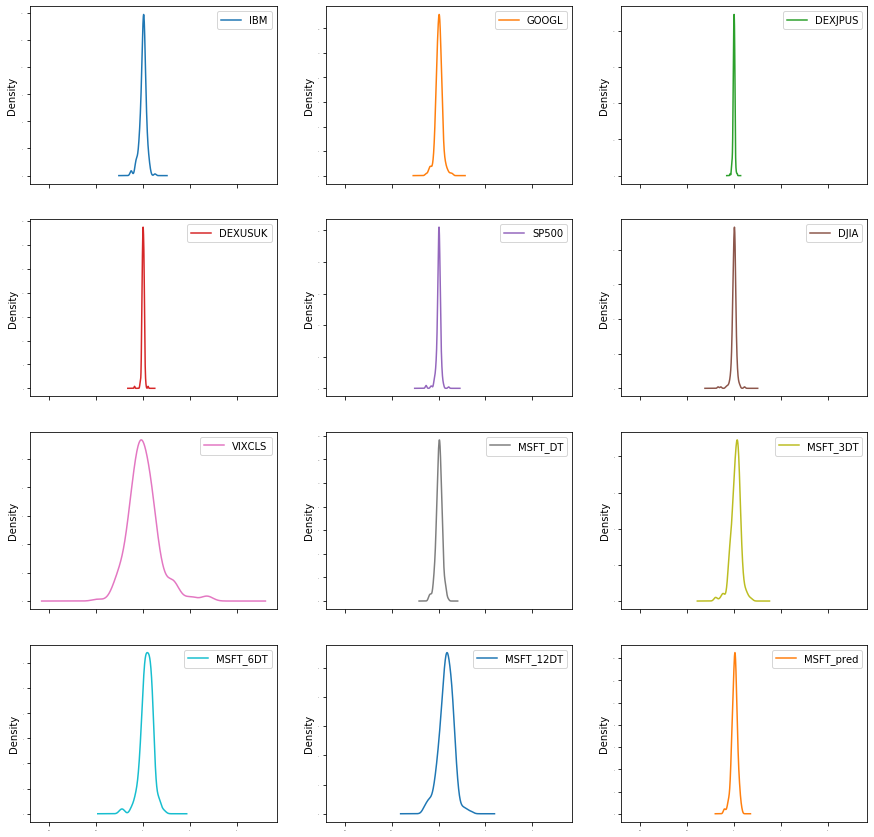

In [29]:
dataset.plot(kind='density', subplots=True, layout=(4,3), legend=True, fontsize=1, sharex=True, figsize=(15,15));

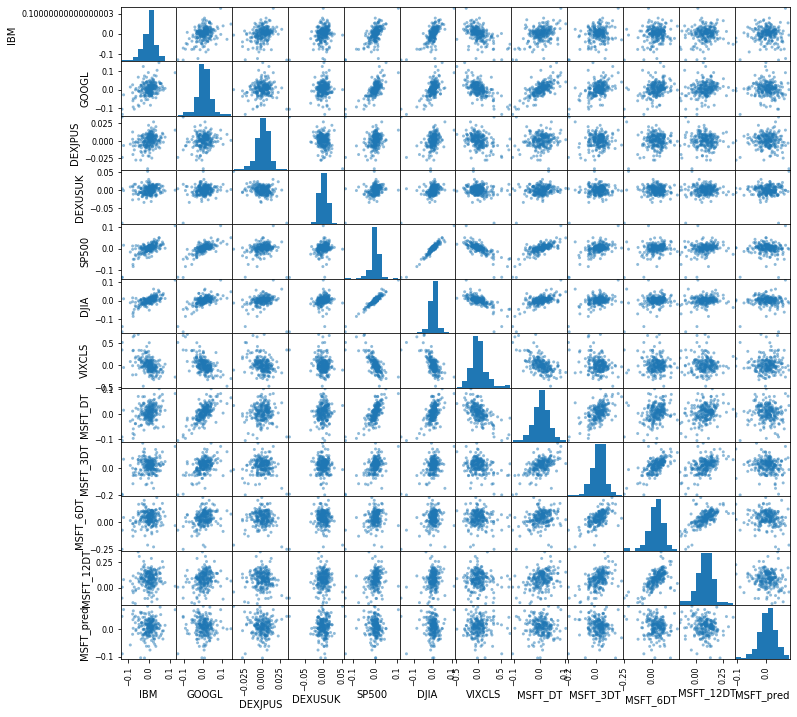

In [30]:
scatter_matrix(dataset, figsize=(12,12));

##### 3.3 Time Series Analysis

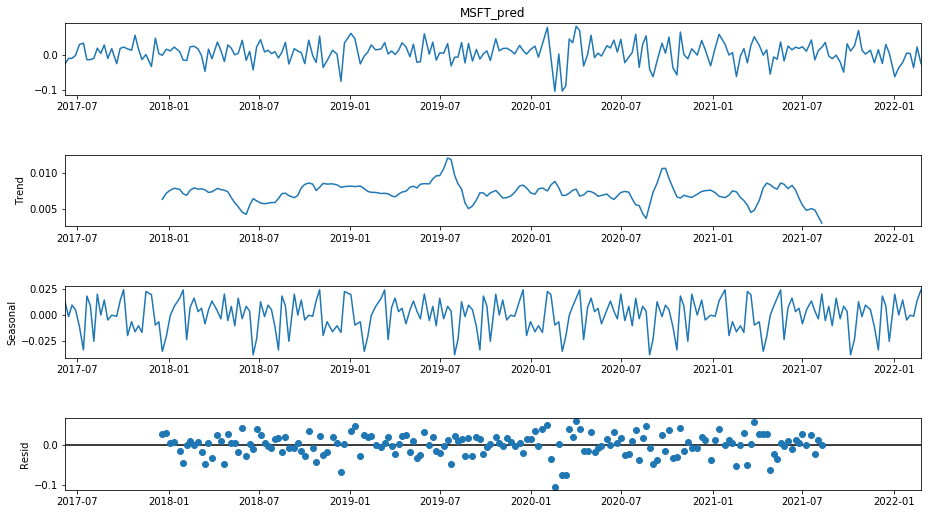

In [31]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 4. Data Preparation
###### 4.2. Feature Selection

In [32]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.nlargest(10, 'Score').set_index('Specs')

,Score
Specs,
MSFT_6DT,5.198
MSFT_12DT,3.582
MSFT_3DT,1.645
GOOGL,0.242
DEXUSUK,0.214
MSFT_DT,0.138
DEXJPUS,0.094
DJIA,0.041
VIXCLS,0.024


#### 5. Evalute Algorithms and models

##### 5.1 Train test split and evaluation metrics

In [33]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

##### 5.2 Test Options and evaluation metrics

In [34]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

##### 5.3 Compare Models and Algorithms

###### 5.3.1 Machine learning models from scikit-learn

In [35]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('RID', Ridge()))

models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))


# Neural Network algorithms
models.append(('LR', MLPRegressor()))

# Ensamble models
#  Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

#  Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [54]:
names = []
kfold_results = []
train_results = []

test_results = []

for name, model in models:
    names.append(name)
    
    # K Fold analysis:
    kfold = KFold(n_splits=num_folds)
    cv_result = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_result)
    
    # Full training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    print("%s: %f (%f) %f %f" % (name, cv_result.mean(), cv_result.std(), train_result, test_result))

LR: 0.001142 (0.001168) 0.000867 0.000982
LASSO: 0.000951 (0.000808) 0.000948 0.000787
EN: 0.000951 (0.000808) 0.000948 0.000787
RID: 0.000967 (0.000871) 0.000908 0.000842
KNN: 0.001127 (0.000869) 0.000730 0.001045
CART: 0.002097 (0.001754) 0.000000 0.002065
SVR: 0.001271 (0.000727) 0.001286 0.001015
LR: 0.002145 (0.001899) 0.001992 0.001633
ABR: 0.001042 (0.001025) 0.000478 0.001013
GBR: 0.001296 (0.001079) 0.000082 0.001292
RFR: 0.001074 (0.000978) 0.000170 0.001166
ETR: 0.001089 (0.000977) 0.000000 0.001259


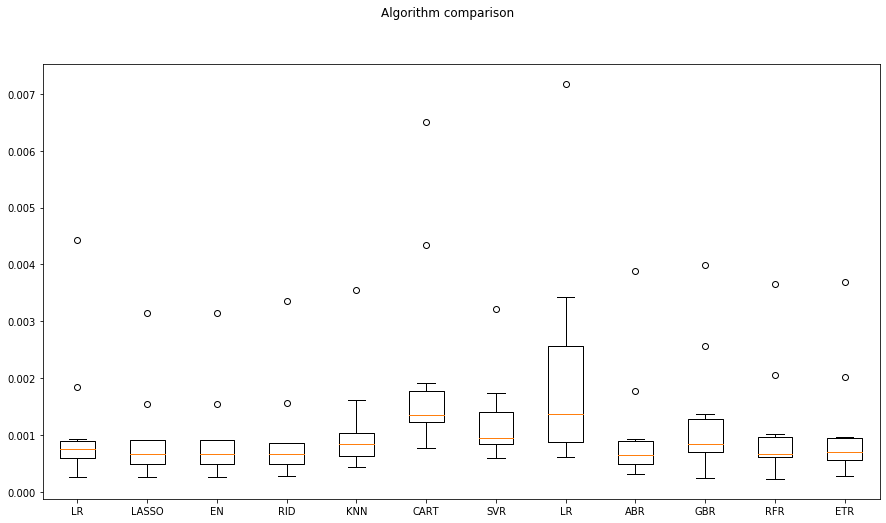

In [55]:
fig = pyplot.figure()
fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

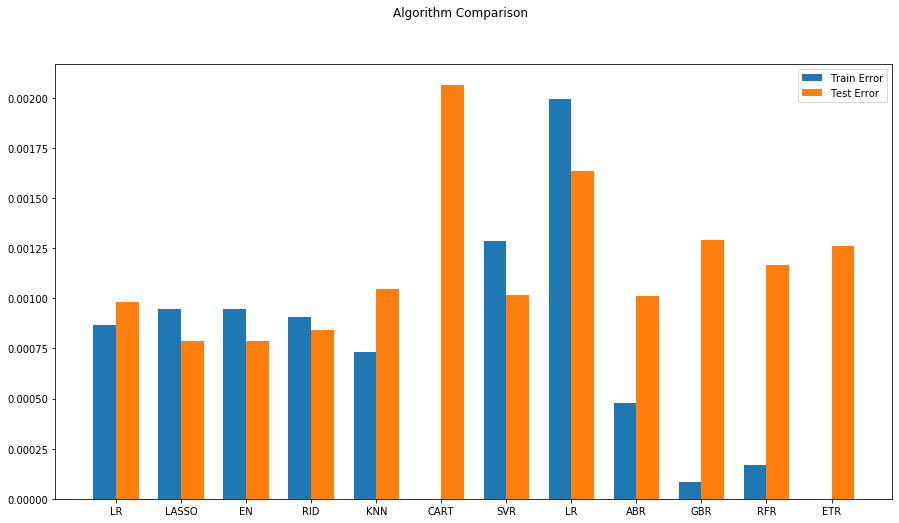

In [56]:
def plot_errors():
    fig = pyplot.figure()
    ind = np.arange(len(names))
    width = 0.35

    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    pyplot.bar(ind - width/2, train_results, width=width, label='Train Error')
    pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
    fig.set_size_inches(15,8)
    pyplot.legend()
    ax.set_xticks(ind)
    ax.set_xticklabels(names)
    pyplot.show()

plot_errors()

### Time series model - ARIMA model

In [57]:
X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])
model_fit = modelARIMA.fit()

In [58]:
error_Train_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len-1, end = to_len-1, exog= X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test, predicted)

In [59]:
error_Test_ARIMA

0.0008109578840739394

### LSTM Model

In [60]:
seq_len = 2 # Length of the seq for the LSTM

Y_train_LSTM = np.array(Y_train)[seq_len-1:]
Y_test_LSTM = np.array(Y_test)

X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))

for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [61]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model

LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

In [62]:
LSTMModel_fit

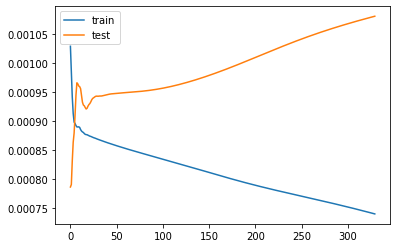

In [63]:
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [64]:
error_Train_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

In [65]:
error_Train_LSTM

0.0007373798279912903

In [66]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Train_ARIMA)
train_results.append(error_Train_LSTM)

names.append("ARIMA")
names.append("LSTM")

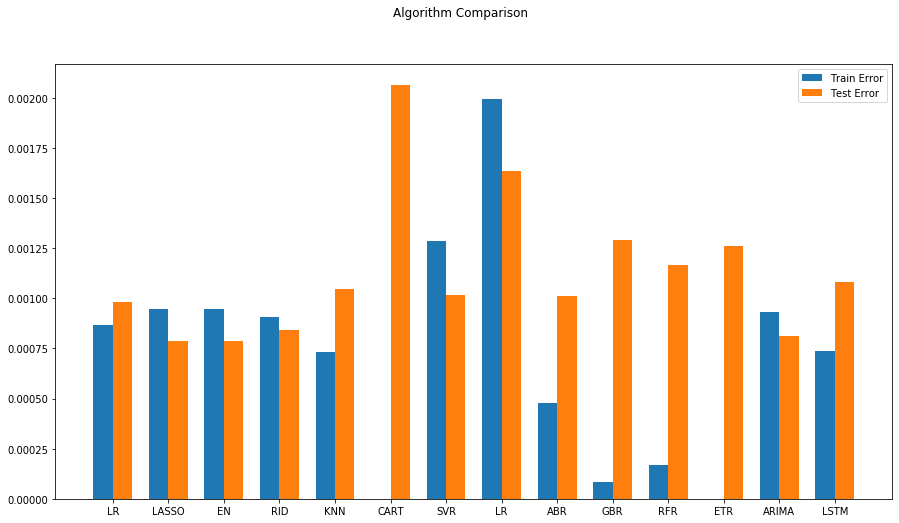

In [67]:
plot_errors()

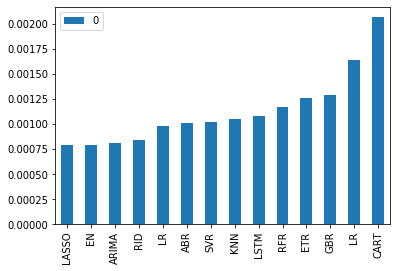

In [68]:
pd.DataFrame(test_results, index=names).sort_values(0).plot(kind='bar');

### Model tuning and Grid search

In [69]:
def evaluate_arima_model(arima_order, enforce_stationarity):
    """arima_order: (p,q,d) tuple"""

    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order,enforce_stationarity=enforce_stationarity)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

evaluate_arima_model([1,0,2], False)

0.0008267650841163668

In [70]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values, enforce_stationarity): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for es in enforce_stationarity:
                    order = (p,d,q)               
                    mse = evaluate_arima_model(order, es)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, (order, es)
                        print('Found new best order', order)
                    print('ARIMA%s MSE=%.7f' % ((order, es),mse))

    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 3]
d_values = [0]
q_values = [0, 1, 2]
enforce_stationarity = [True, False]

evaluate_models(p_values, d_values, q_values, enforce_stationarity)   

Found new best order (0, 0, 0)
ARIMA((0, 0, 0), True) MSE=0.0009331
ARIMA((0, 0, 0), False) MSE=0.0009331
Found new best order (0, 0, 1)
ARIMA((0, 0, 1), True) MSE=0.0009331
ARIMA((0, 0, 1), False) MSE=0.0009332
Found new best order (0, 0, 2)
ARIMA((0, 0, 2), True) MSE=0.0009074
Found new best order (0, 0, 2)
ARIMA((0, 0, 2), False) MSE=0.0009056
ARIMA((1, 0, 0), True) MSE=0.0009331
ARIMA((1, 0, 0), False) MSE=0.0009331
Found new best order (1, 0, 1)
ARIMA((1, 0, 1), True) MSE=0.0008986
Found new best order (1, 0, 1)
ARIMA((1, 0, 1), False) MSE=0.0008551
Found new best order (1, 0, 2)
ARIMA((1, 0, 2), True) MSE=0.0008265
ARIMA((1, 0, 2), False) MSE=0.0008268
ARIMA((2, 0, 0), True) MSE=0.0009162
ARIMA((2, 0, 0), False) MSE=0.0009164
ARIMA((2, 0, 1), True) MSE=0.0008917
ARIMA((2, 0, 1), False) MSE=0.0009026
ARIMA((2, 0, 2), True) MSE=0.0008787
ARIMA((2, 0, 2), False) MSE=0.0008889
ARIMA((3, 0, 0), True) MSE=0.0009149
ARIMA((3, 0, 0), False) MSE=0.0009153
ARIMA((3, 0, 1), True) MSE=0.0009

#### Finalise the model

In [71]:
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [72]:
predicted_tuned = model_fit_tuned.predict(start = tr_len-1, end = to_len-1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test, predicted_tuned))

0.000790059508511598


### Save model for later use

In [75]:
from pickle import dump, load

dump(model_fit_tuned, open('final_model.sav', 'wb'))

In [76]:
model = load(open('final_model.sav', 'rb'))

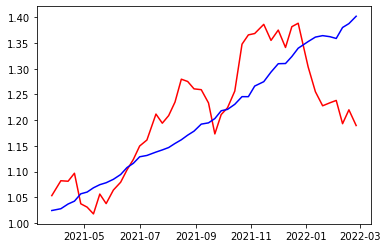

In [88]:
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r')
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.show()